# Final eval

In [1]:
import os
from typing import Callable, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes

In [2]:
sns.set_palette('colorblind')

in_dir = os.path.join('..', 'output', 'final_eval', 'results')
base_out_dir = os.path.join('..', 'output', 'final_eval', 'plots')

In [3]:
def load_results(name: str, player_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_raw = pd.read_csv(os.path.join(in_dir, f'{name}.csv'))

    desired_idx_cols = ['game_no', 'round_no', 'trick_no']
    df_raw['hearts_pts'] = np.where(df_raw['card_played'] // 13 == 3, 1, 0)
    df_raw['q_spade_pts'] = np.where(df_raw['card_played'] == 36, 13, 0)

    trick_winners = df_raw.loc[df_raw['is_trick_winner'], [*desired_idx_cols, 'player_idx']]
    trick_points = df_raw[[*desired_idx_cols, 'hearts_pts', 'q_spade_pts']] \
        .groupby(desired_idx_cols) \
        .sum() \
        .reset_index()
    trick_points['total_pts'] = trick_points['hearts_pts'] + trick_points['q_spade_pts']

    df_tricks = pd.merge(
        trick_winners,
        trick_points,
        on=desired_idx_cols,
    )
    player_names_df = pd.DataFrame({'player_name': player_names}) \
        .reset_index(names='player_idx')
    df_tricks = pd.merge(
        df_tricks,
        player_names_df,
        on='player_idx',
    )

    # calculate df for round scores separately to account for moon shots
    df_rounds = df_tricks\
        .groupby(['game_no', 'round_no', 'player_idx', 'player_name'])['total_pts']\
        .sum()\
        .reset_index()
    is_moon_shot = df_rounds['total_pts'] == 26
    round_idx_where_moon_shot = df_rounds.loc[is_moon_shot, ['game_no', 'round_no']]
    df_rounds['is_moon_shot'] = is_moon_shot

    for _, round_idx in round_idx_where_moon_shot.iterrows():
        round_indexer = ((df_rounds['game_no'] == round_idx['game_no']) 
                         & (df_rounds['round_no'] == round_idx['round_no']))
        
        pts_for_round = df_rounds.loc[round_indexer, 'total_pts']
        df_rounds.loc[round_indexer, 'total_pts'] = 26 - pts_for_round

    return df_tricks, df_rounds


In [4]:
def plot(fig_id: str, 
         fig_title: str, 
         ylabel: str,
         ylim: tuple[float, float] | None = None,
         baseline_y: float | None = None):
    """
    A decorator for all plots

    Features:
    - Automatically supply ``ax`` parameter to the method as the first parameter
    - Save & show the figure
    - Add labels for axes
    - Display a horizontal dotted line for baseline value (optional)
    """

    def decorator(plotting_func: Callable[[pd.DataFrame, Axes], Any]):
        def wrapper(df: pd.DataFrame, out_dir: str) -> Any:
            fig, ax = plt.subplots(figsize=(8, 3), dpi=120)

            result = plotting_func(df, ax)

            fig.tight_layout()
            ax.grid(visible=True, axis='y')
            ax.set_xlabel('')
            ax.set_ylabel(ylabel)

            if baseline_y is not None:
                ax.axhline(
                    y=baseline_y,
                    linestyle='--',
                    color='black',
                    linewidth=2,
                )
            if ylim is not None:
                ax.set_ylim(ylim)

            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f'{fig_id}.png'))
            ax.set_title(fig_title)
            plt.show()

            return result

        return wrapper

    return decorator


In [5]:
@plot(fig_id='win_rate_games', 
      fig_title='Full game win %', 
      ylabel='Win %', 
      ylim=(0, 100))
def plot_win_rate_games(df_rounds: pd.DataFrame, ax: Axes):
    df_game_pts = df_rounds\
        .groupby(['game_no', 'player_name'])['total_pts']\
        .sum()\
        .reset_index()
    winners = df_game_pts\
        .loc[df_game_pts.groupby('game_no')['total_pts'].idxmin()]\
        .sort_values('player_name')['player_name']        
    
    win_perc = winners.value_counts(normalize=True, sort=False) * 100
    win_counts = winners.value_counts(sort=False)

    print(win_counts)
    print(win_perc)
    sns.barplot(
        ax=ax,
        x=win_perc.index, 
        y=win_perc.values,
    )

In [6]:
@plot(fig_id='scores_rounds', 
      fig_title='Scores in rounds', 
      ylabel='Points')
def plot_avg_score_rounds(df_rounds: pd.DataFrame, ax: Axes):    
    df_round_avg_pts = df_rounds\
        .groupby('player_name')['total_pts']\
        .mean()\
        .reset_index()
    print('Avg. scores:')
    print(df_round_avg_pts)

    sns.boxplot(
        ax=ax,
        data=df_rounds,
        x='player_name',
        y='total_pts',
    )

In [7]:
@plot(fig_id='scores_games', 
      fig_title='Scores in full games', 
      ylabel='Points')
def plot_avg_score_games(df_rounds: pd.DataFrame, ax: Axes):
    df_game_total_pts = df_rounds.groupby(['game_no', 'player_idx', 'player_name'])['total_pts']\
        .sum()\
        .reset_index()
    
    df_game_avg_points = df_game_total_pts\
        .groupby('player_name')['total_pts']\
        .mean()\
        .reset_index()
    print('Avg. scores:')
    print(df_game_avg_points)

    sns.boxplot(
        ax=ax,
        data=df_game_total_pts,
        x='player_name',
        y='total_pts',
    )

In [8]:
@plot('hearts_taken', 'Hearts taken', '% of all hearts taken')
def plot_total_hearts(df_tricks: pd.DataFrame, ax: Axes):
    hearts_taken_df = df_tricks.groupby('player_name')\
        .sum()\
        .reset_index()\
        .sort_values('player_name')
    hearts_pts = hearts_taken_df['hearts_pts']
    hearts_taken_df['hearts_perc'] = hearts_pts / hearts_pts.sum() * 100
    hearts_taken_df = hearts_taken_df[['player_name', 'hearts_perc', 'hearts_pts']]
    
    print(hearts_taken_df)
    sns.barplot(
        ax=ax,
        data=hearts_taken_df,
        x='player_name',
        y='hearts_perc',
    )

In [9]:
@plot('q_spades_taken', 'Q♠ taken', '% of Q♠ taken')
def plot_total_q_spades(df_tricks: pd.DataFrame, ax: Axes):
    q_spades_df = df_tricks.groupby('player_name')\
        .sum()\
        .reset_index()\
        .sort_values('player_name')
    q_spades_taken = q_spades_df['q_spade_pts'] / 13
    q_spades_df['q_spades_taken'] = q_spades_taken
    q_spades_df['q_spades_perc'] = q_spades_taken / q_spades_taken.sum() * 100
    q_spades_df = q_spades_df[['player_name', 'q_spades_perc', 'q_spades_taken']]

    print(q_spades_df)
    sns.barplot(
        ax=ax,
        data=q_spades_df,
        x='player_name',
        y='q_spades_perc',
    )

In [10]:
@plot('moon_shots', 'Moon shots', 'Number of moon shots')
def plot_moon_shots(df_rounds: pd.DataFrame, ax: Axes):
    df_moon_shots = df_rounds.groupby('player_name')\
        .sum()\
        .reset_index()\
        .sort_values('player_name')\
        .rename(columns={'is_moon_shot': 'moon_shot_count'})
    df_moon_shots = df_moon_shots[['player_name', 'moon_shot_count']]

    print(df_moon_shots)
    sns.barplot(
        ax=ax,
        data=df_moon_shots,
        x='player_name',
        y='moon_shot_count',
    )

In [11]:
def results_pipeline(name: str, player_names: list[str]) -> None:
    out_dir = os.path.join(base_out_dir, name)
    os.makedirs(out_dir, exist_ok=True)
    df_tricks, df_rounds = load_results(name, player_names)

    plot_avg_score_games(df_rounds, out_dir)
    plot_avg_score_rounds(df_rounds, out_dir)
    plot_win_rate_games(df_rounds, out_dir)
    plot_total_hearts(df_tricks, out_dir)
    plot_total_q_spades(df_tricks, out_dir)
    plot_moon_shots(df_rounds, out_dir)

# 2x PPO vs 2x Random

Avg. scores:
  player_name  total_pts
0         PPO    39.9065
1      Random    88.2735


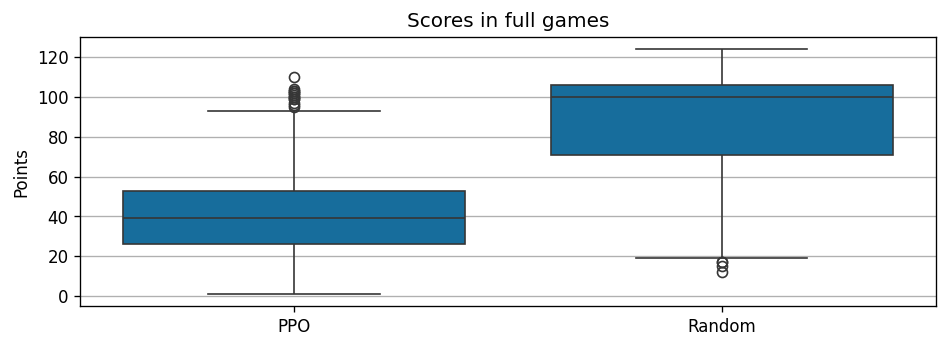

Avg. scores:
  player_name  total_pts
0         PPO   4.782085
1      Random   9.398297


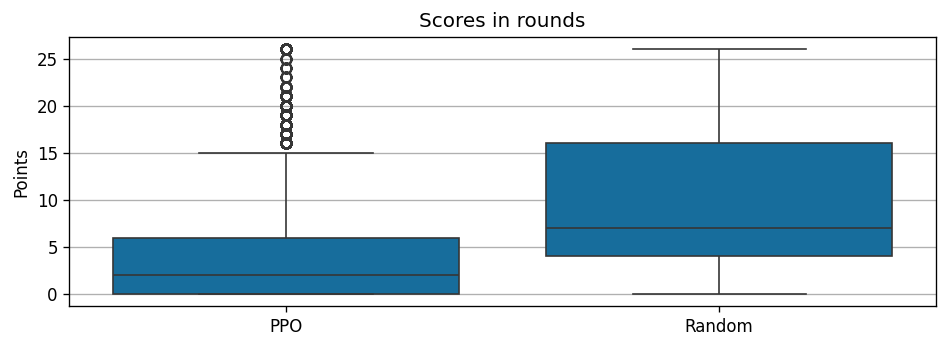

player_name
PPO       992
Random      8
Name: count, dtype: int64
player_name
PPO       99.2
Random     0.8
Name: proportion, dtype: float64


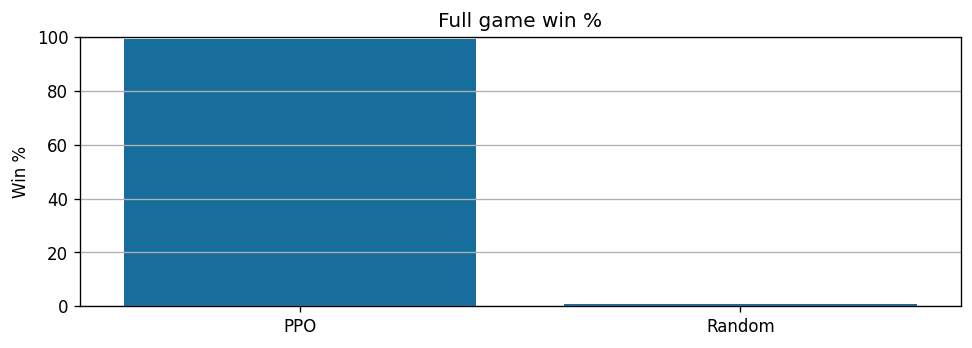

  player_name  hearts_perc  hearts_pts
0         PPO    28.853131       36185
1      Random    71.146869       89226


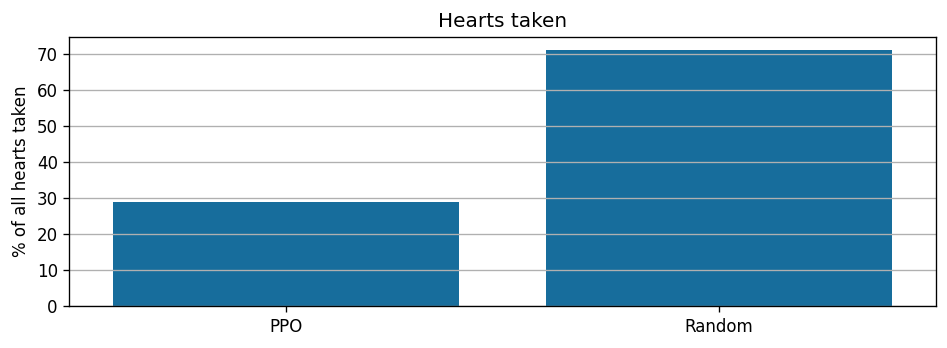

  player_name  q_spades_perc  q_spades_taken
0         PPO      30.309941          2924.0
1      Random      69.690059          6723.0


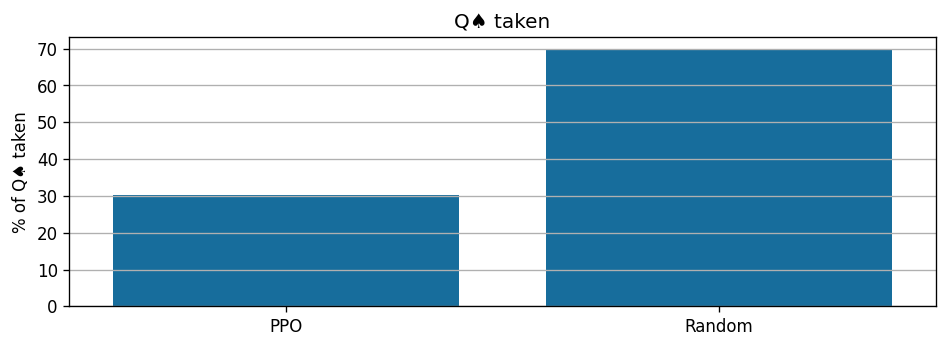

  player_name  moon_shot_count
0         PPO               16
1      Random              176


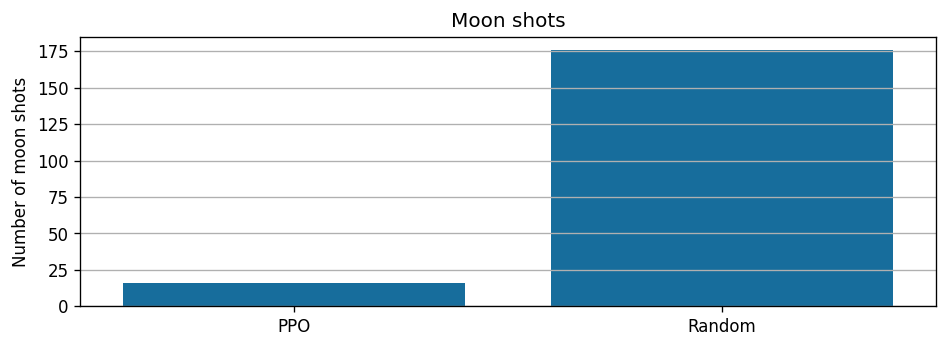

In [12]:
results_pipeline('ppo_vs_random', ['PPO', 'PPO', 'Random', 'Random'])

# 2x MCTS+RL vs 2x Random

Avg. scores:
  player_name  total_pts
0     MCTS+RL     42.941
1      Random     88.398


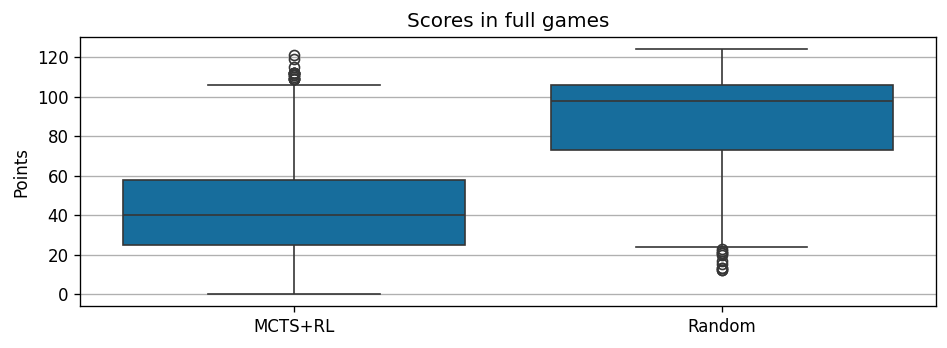

Avg. scores:
  player_name  total_pts
0     MCTS+RL   4.953969
1      Random   9.218207


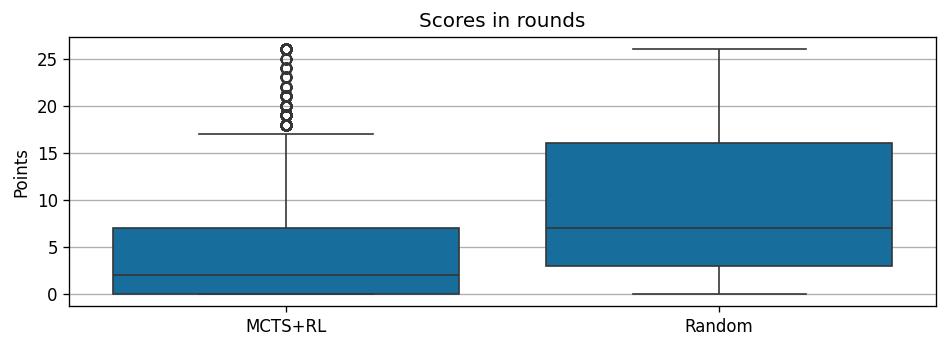

player_name
MCTS+RL    979
Random      21
Name: count, dtype: int64
player_name
MCTS+RL    97.9
Random      2.1
Name: proportion, dtype: float64


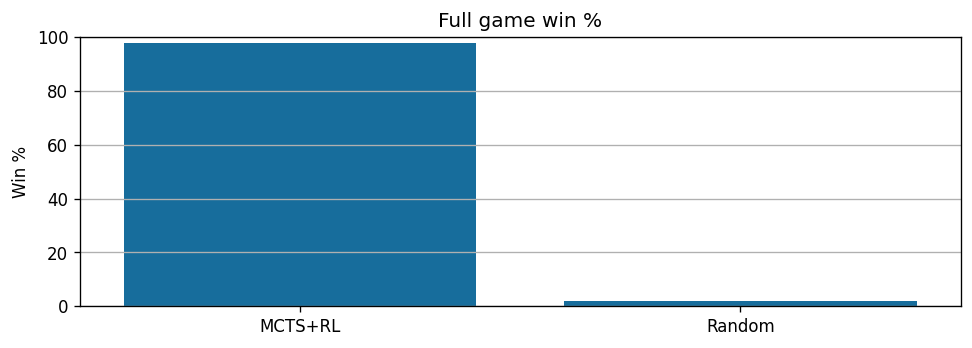

  player_name  hearts_perc  hearts_pts
0     MCTS+RL    29.444635       37834
1      Random    70.555365       90658


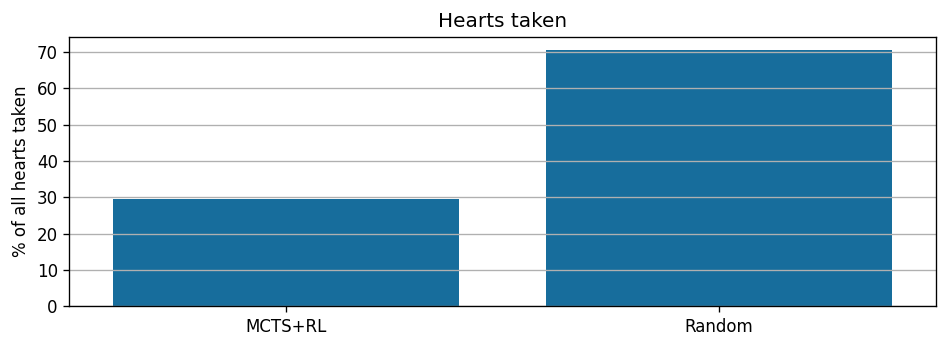

  player_name  q_spades_perc  q_spades_taken
0     MCTS+RL      32.679077          3230.0
1      Random      67.320923          6654.0


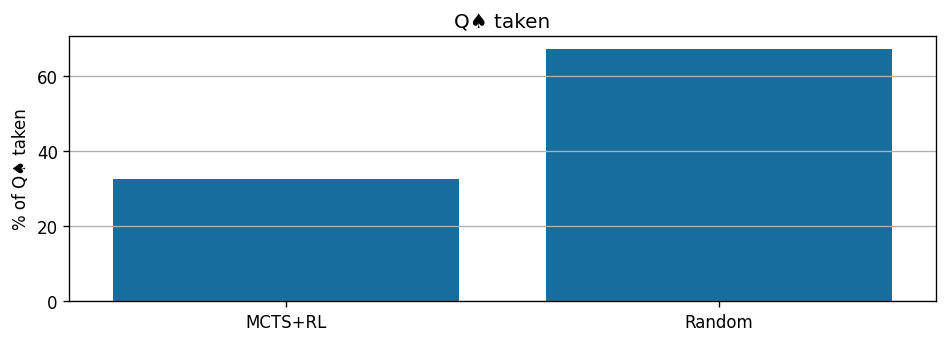

  player_name  moon_shot_count
0     MCTS+RL                8
1      Random              184


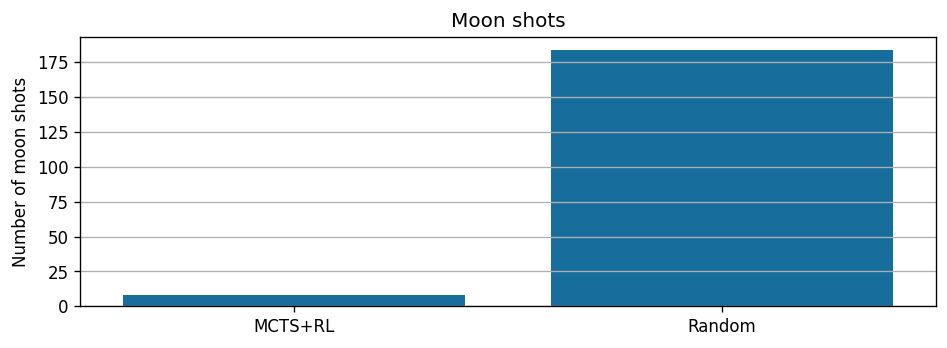

In [13]:
results_pipeline('mctsrl_vs_random', ['MCTS+RL', 'MCTS+RL', 'Random', 'Random'])

# 2x PPO vs 2x Rule-based

Avg. scores:
  player_name  total_pts
0         PPO     85.021
1  Rule-based     48.424


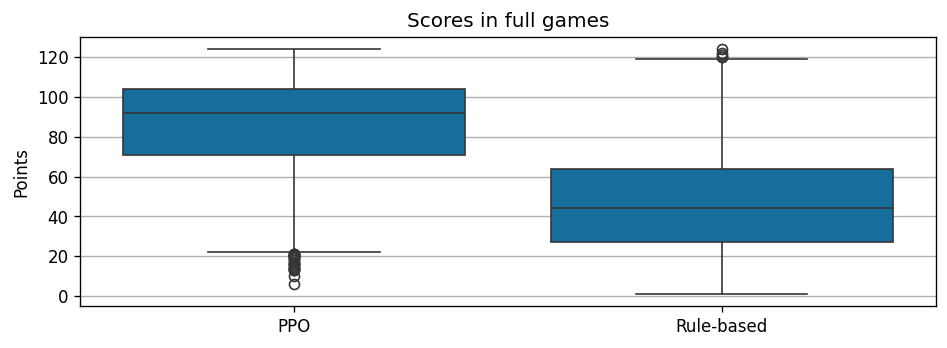

Avg. scores:
  player_name  total_pts
0         PPO   8.824183
1  Rule-based   5.739481


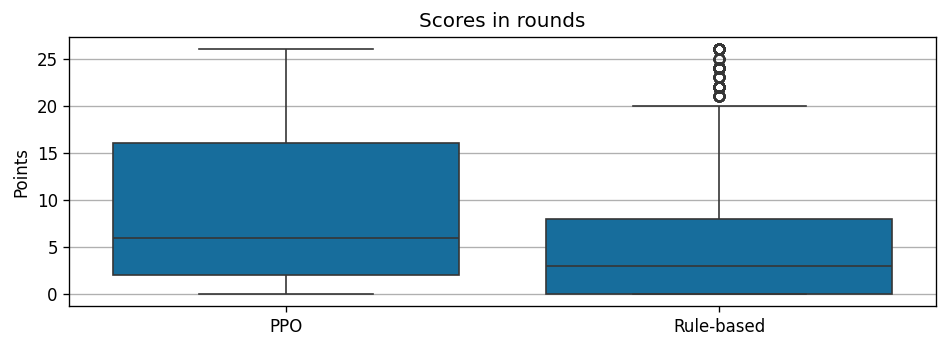

player_name
PPO            42
Rule-based    958
Name: count, dtype: int64
player_name
PPO            4.2
Rule-based    95.8
Name: proportion, dtype: float64


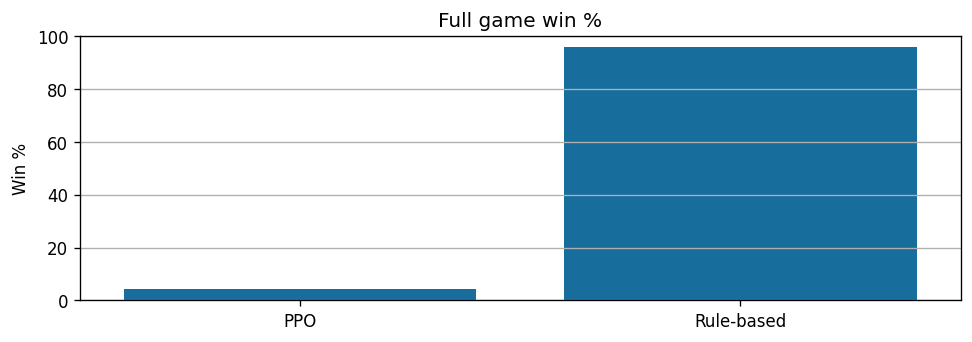

  player_name  hearts_perc  hearts_pts
0         PPO     58.41619       76260
1  Rule-based     41.58381       54286


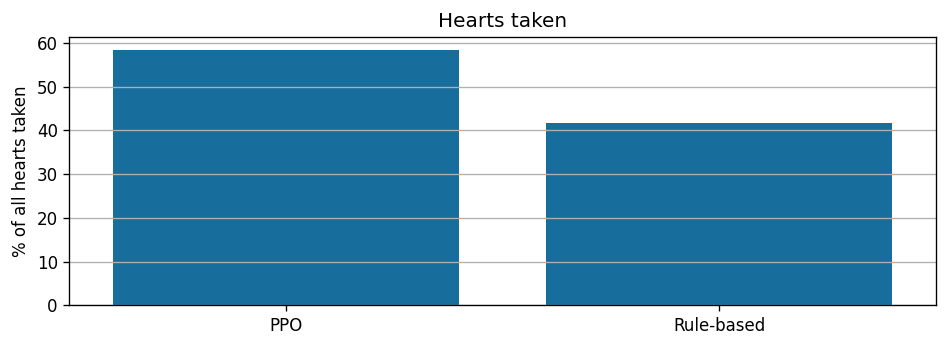

  player_name  q_spades_perc  q_spades_taken
0         PPO      73.292173          7360.0
1  Rule-based      26.707827          2682.0


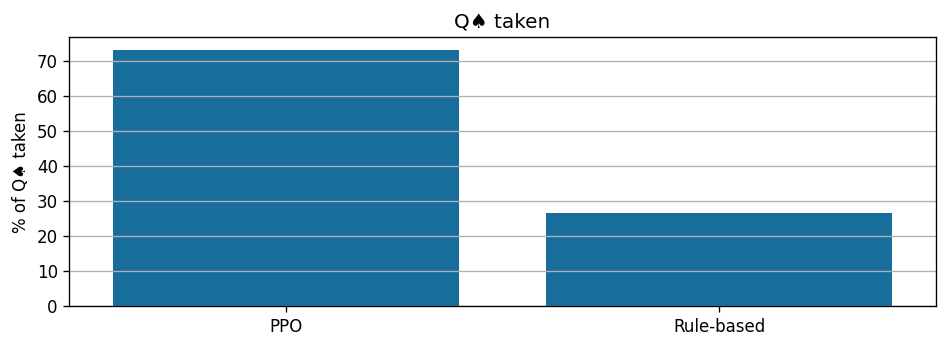

  player_name  moon_shot_count
0         PPO              226
1  Rule-based                8


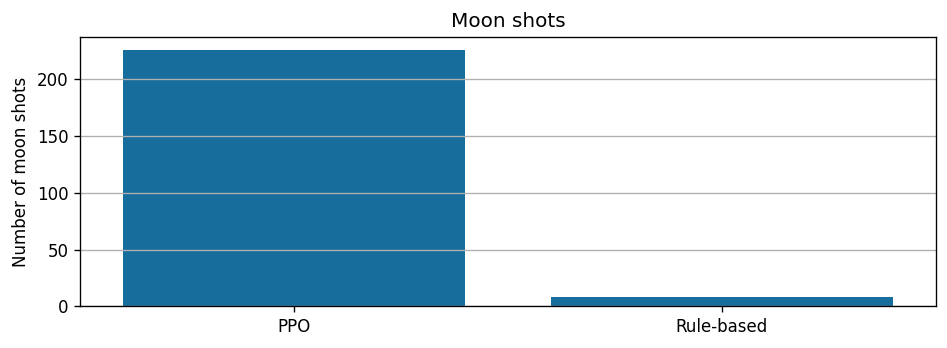

In [14]:
results_pipeline('ppo_vs_rule_based', ['PPO', 'PPO', 'Rule-based', 'Rule-based'])

# 2x MCTS+RL vs 2x Rule-based

Avg. scores:
  player_name  total_pts
0     MCTS+RL    74.9375
1  Rule-based    25.9425


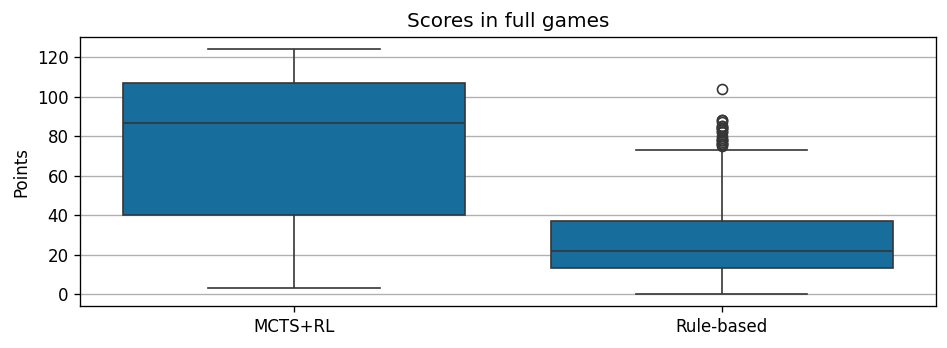

Avg. scores:
  player_name  total_pts
0     MCTS+RL  10.299979
1  Rule-based   4.743555


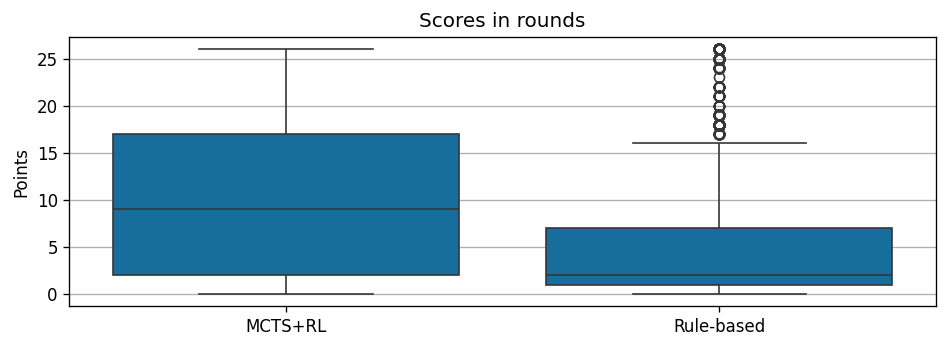

player_name
MCTS+RL         1
Rule-based    999
Name: count, dtype: int64
player_name
MCTS+RL        0.1
Rule-based    99.9
Name: proportion, dtype: float64


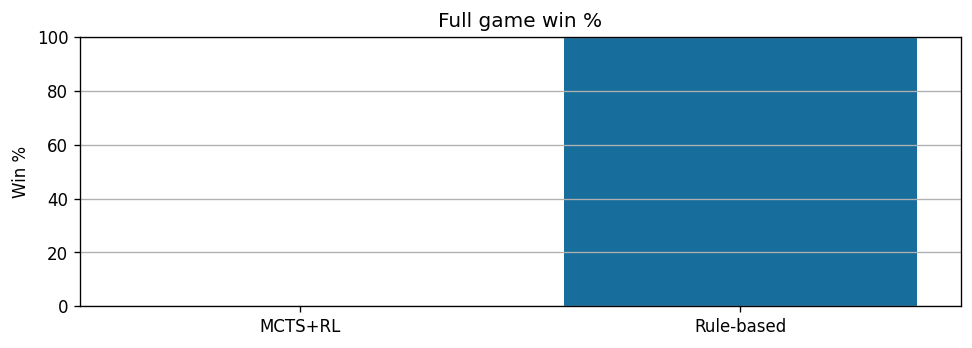

  player_name  hearts_perc  hearts_pts
0     MCTS+RL    63.097477       61397
1  Rule-based    36.902523       35908


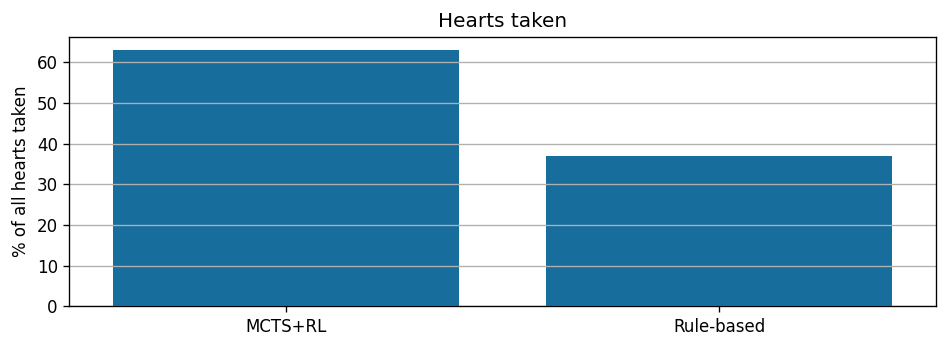

  player_name  q_spades_perc  q_spades_taken
0     MCTS+RL      90.447562          6770.0
1  Rule-based       9.552438           715.0


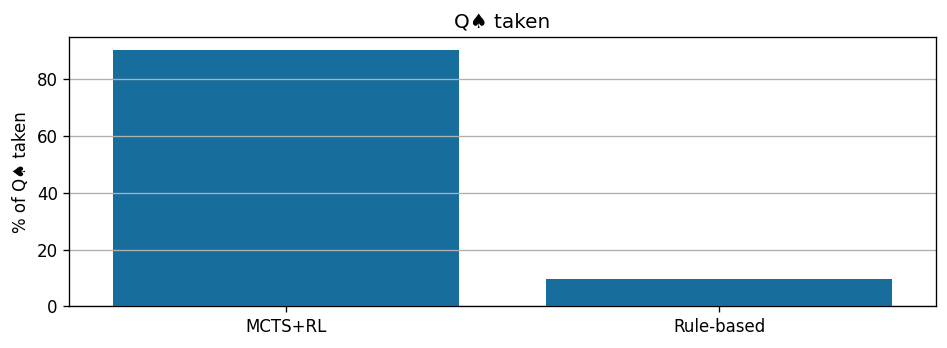

  player_name  moon_shot_count
0     MCTS+RL              230
1  Rule-based               39


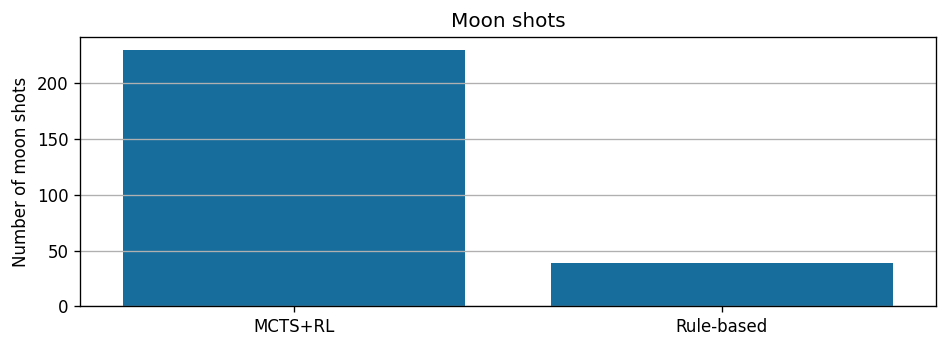

In [15]:
results_pipeline('mctsrl_vs_rule_based', ['MCTS+RL', 'MCTS+RL', 'Rule-based', 'Rule-based'])

# Tournament

Avg. scores:
  player_name  total_pts
0     MCTS+RL     69.447
1         PPO     60.097
2      Random    101.972
3  Rule-based     20.164


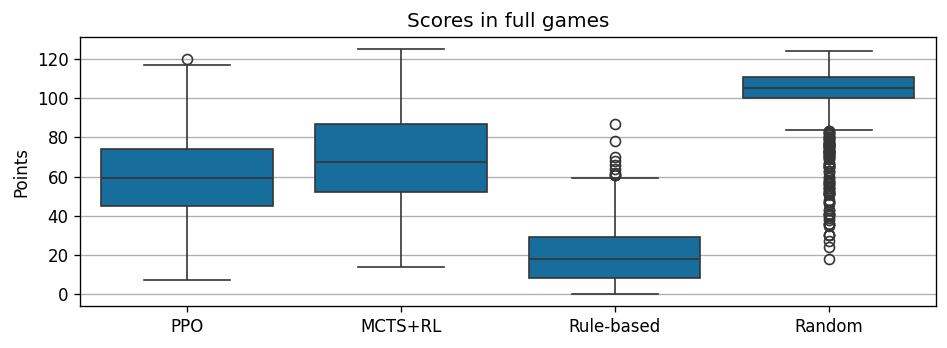

Avg. scores:
  player_name  total_pts
0     MCTS+RL   8.024844
1         PPO   7.226671
2      Random  10.868898
3  Rule-based   3.409537


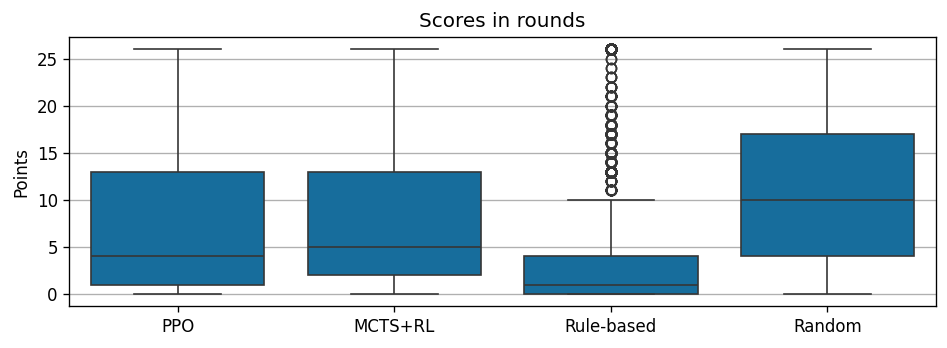

player_name
MCTS+RL        19
PPO            57
Random          5
Rule-based    919
Name: count, dtype: int64
player_name
MCTS+RL        1.9
PPO            5.7
Random         0.5
Rule-based    91.9
Name: proportion, dtype: float64


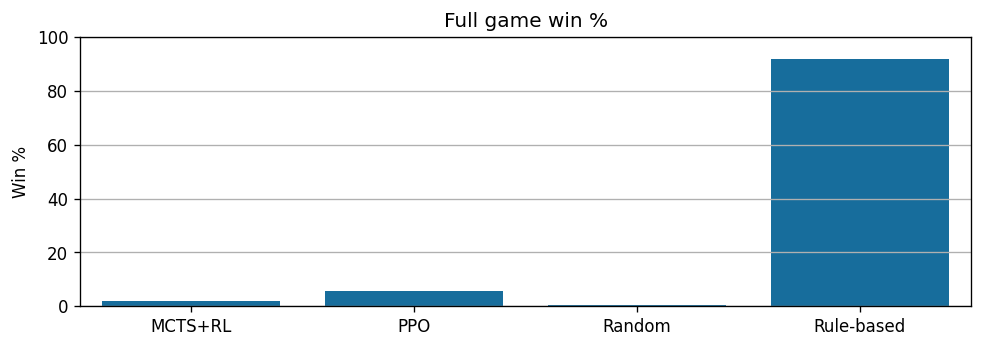

  player_name  hearts_perc  hearts_pts
0     MCTS+RL    30.589676       37480
1         PPO    21.589880       26453
2      Random    39.915119       48906
3  Rule-based     7.905325        9686


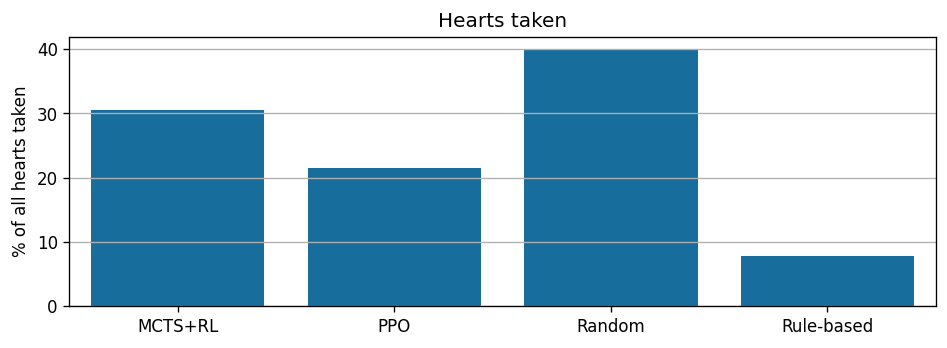

  player_name  q_spades_perc  q_spades_taken
0     MCTS+RL      23.267905          2193.0
1         PPO      26.907162          2536.0
2      Random      43.968170          4144.0
3  Rule-based       5.856764           552.0


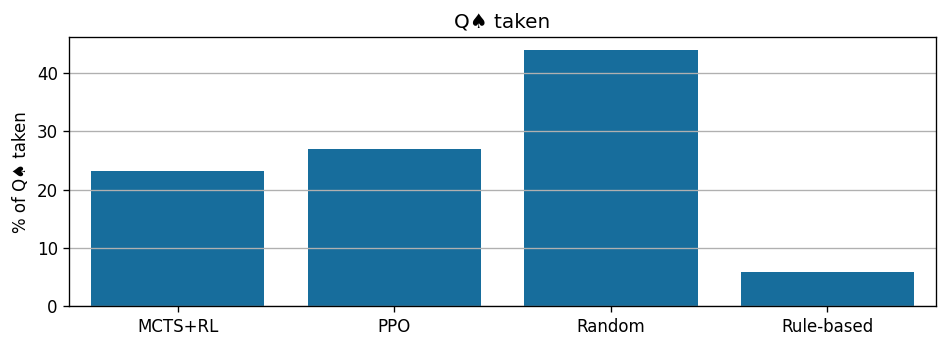

  player_name  moon_shot_count
0     MCTS+RL               23
1         PPO               74
2      Random              125
3  Rule-based                0


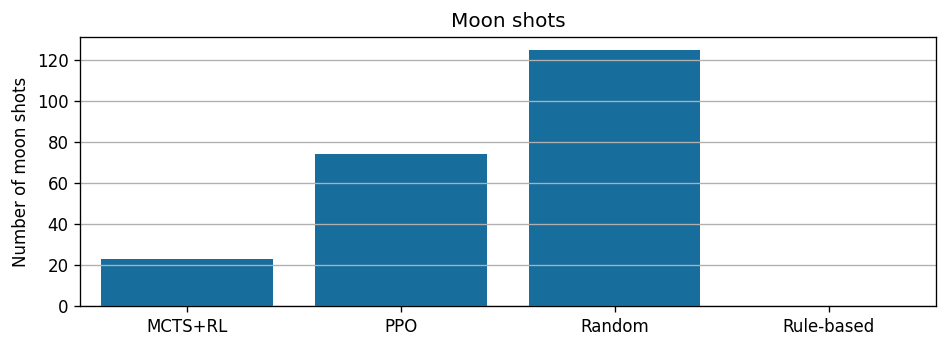

In [16]:
results_pipeline('tournament', ['PPO', 'MCTS+RL', 'Rule-based', 'Random'])